# Voronoi-Otsu-labeling
This workflow for image segmentation is a rather simple and yet powerful approach, e.g. for detecting and segmenting nuclei in fluorescence micropscopy images. A nuclei marker such as nuclei-GFP, DAPI or histone-RFP in combination with various microscopy techniques can be used to generate images of suitable kind.

To demonstrate the workflow, we're using image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC022):
We used image set BBBC022v1 [Gustafsdottir et al., PLOS ONE, 2013](http://dx.doi.org/10.1371/journal.pone.0080999), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083).

In [21]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import pyclesperanto as cle

cle.select_device()

image = imread("../data/BBBC022/IXMtest_A02_s9.tif")[:,:,0]

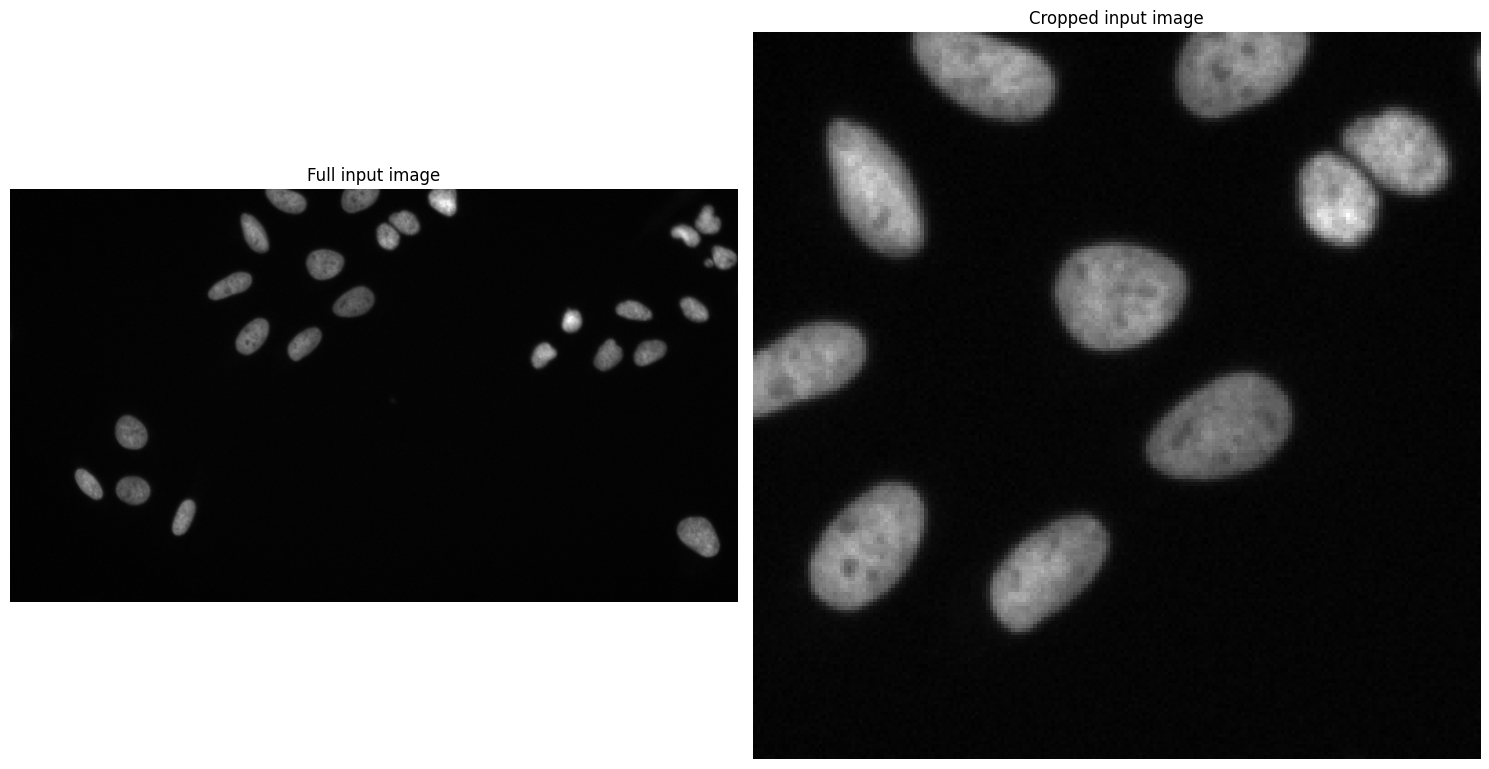

In [22]:
# define an interesting sub-region
bb_x=200
bb_y=0
bb_width=200
bb_height=200

image_crop = cle.crop(image, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(image, cmap="gray")
axs[0].set_title("Full input image")
axs[1].imshow(image_crop, cmap="gray")
axs[1].set_title("Cropped input image")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Applying the algorithm

Voronoi-Otsu-labeling is a function available in clesperanto, which requires an input image and two sigma parameters:   
1 - `spot_sigma` controls the detection of the objects centroids  
2 - `outline_sigma` controls the detection of the objects borders 

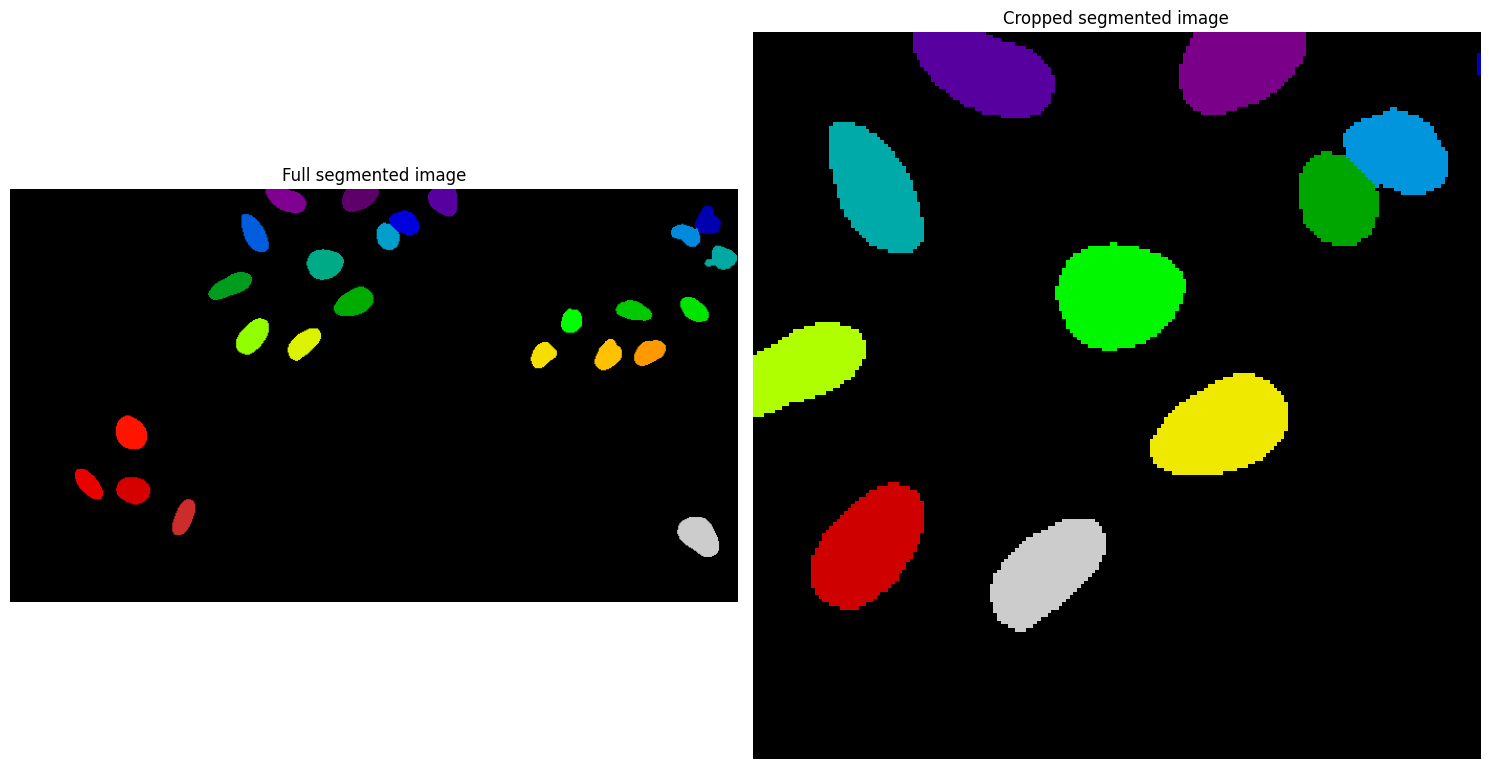

In [23]:
sigma_spot = 5
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(image, spot_sigma=sigma_spot, outline_sigma=sigma_outline)
segmented_crop = cle.crop(segmented, start_x=bb_x, start_y=bb_y, width=bb_width, height=bb_height)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(segmented, cmap="nipy_spectral")
axs[0].set_title("Full segmented image")
axs[1].imshow(segmented_crop, cmap="nipy_spectral")
axs[1].set_title("Cropped segmented image")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

## How does it work?
The Voronoi-Otsu-Labeling workflow is a combination of Gaussian blur, spot detection, Otsu thresholding and binary watershed. The interested reader might want to see the [open source code](https://github.com/clEsperanto/CLIc/blob/c7e0e6b1bdaba38dabe740864917e140d2758470/clic/src/tier7/voronoi_otsu_labeling.cpp#L15-L33). The approach is similar to applying a seeded watershed to a binary image, e.g. in [MorphoLibJ](https://imagej.net/plugins/marker-controlled-watershed) or [scikit-image](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed). However, the seeds are computed automatically using a Gaussian blur and a local maxima detection.

For demonstration purposes we do that only on the 2D cropped image shown above. This approach can be applied to 3D data but it is recommended to make it isotropic first for optimised results.

In [24]:
image_to_segment = image_crop
print(image_to_segment.shape)

(200, 200)


As a first step, we blur the image with a given sigma and detect maxima in the resulting image. 

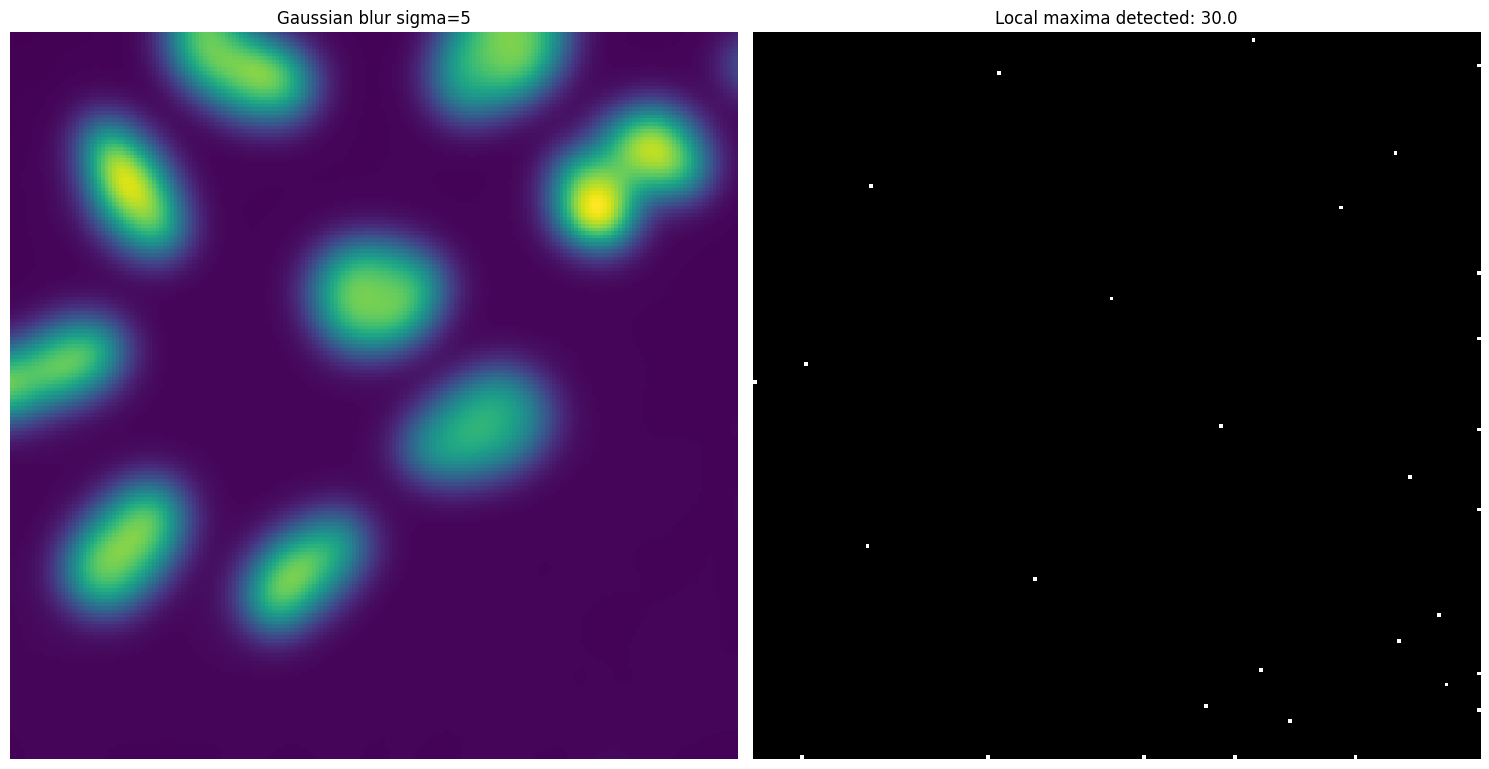

In [25]:
sigma_spot = 5
sigma_outline = 1

blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_spot, sigma_y=sigma_spot, sigma_z=sigma_spot)
detected_spots = cle.detect_maxima_box(blurred, radius_x=0, radius_y=0, radius_z=0)

number_of_detected_spots = cle.sum_of_all_pixels(detected_spots)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(blurred)
axs[0].set_title(f"Gaussian blur sigma={sigma_spot}")
axs[1].imshow(detected_spots, cmap="gray")
axs[1].set_title(f"Local maxima detected: {number_of_detected_spots}")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


We obtain a set of spots which are approximatively at the center of our objects, plus some extra spots outside but this will not be an issue.

Next step is to detect the outline of our objects. We start again from the cropped image and blur it, with a different sigma, and threshold it using [Otsu's thresholding method (Otsu et al 1979)](https://doi.org/10.1109%2FTSMC.1979.4310076) to obtain a binary mask of our objects.

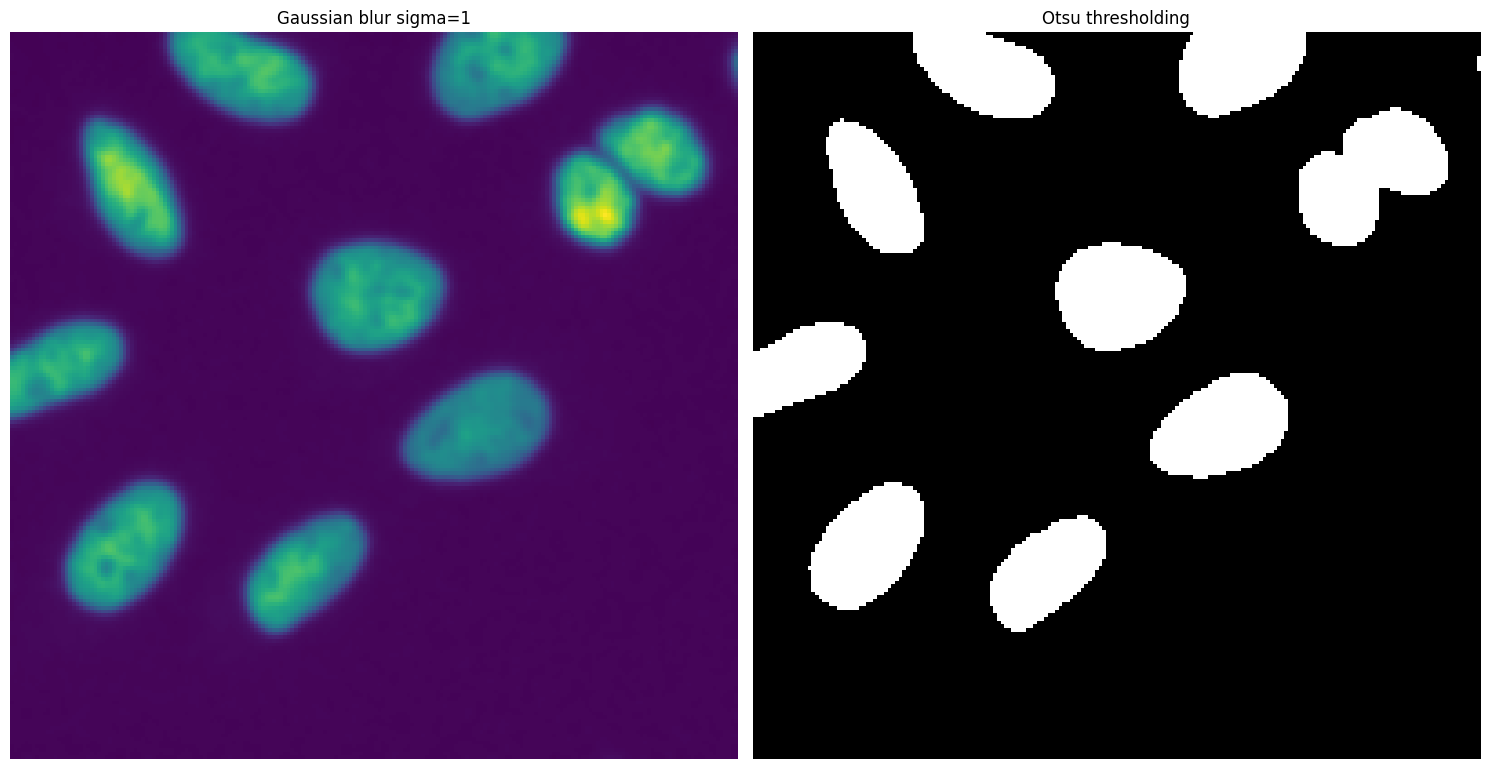

In [26]:
blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)
binary = cle.threshold_otsu(blurred)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(blurred)
axs[0].set_title(f"Gaussian blur sigma={sigma_outline}")
axs[1].imshow(binary, cmap="gray")
axs[1].set_title("Otsu thresholding")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

We have a mask of our object but some can be touching leading to sub-segmentation results and a set of spots but with wrong detection that could lead to sur-segmentation.
We will use both to obtain a precise segmentation.

1 - We filter the spots by remove all spots outside of the object mask, ensuring that we only keep spots located in our object outlines.

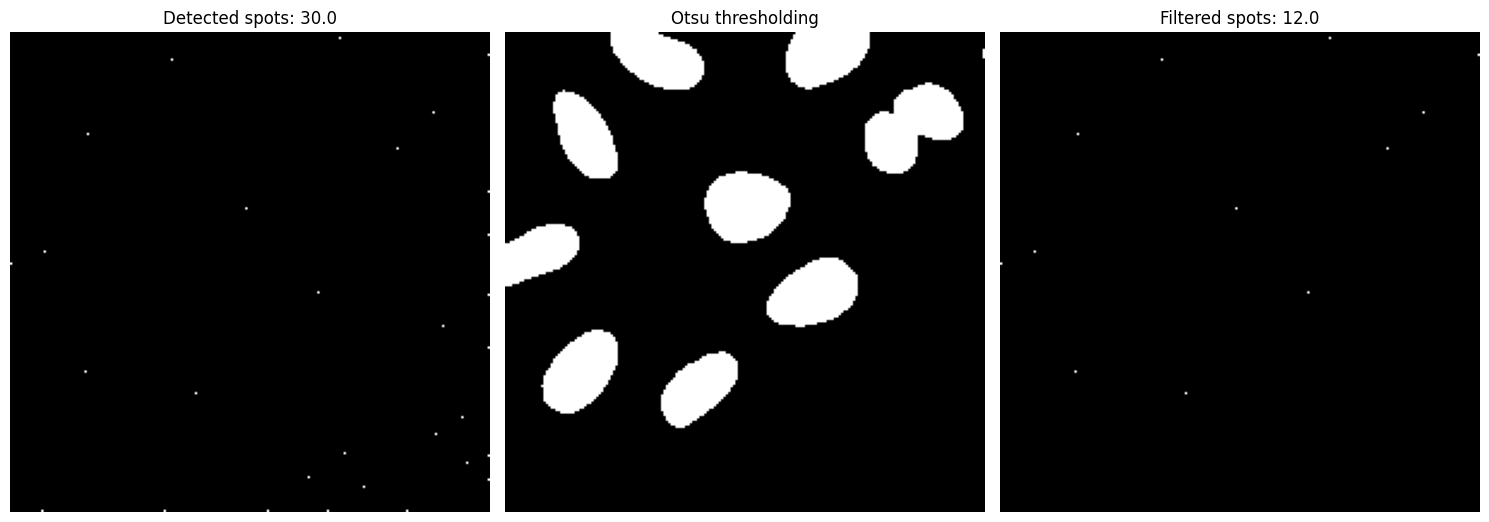

In [27]:
selected_spots = cle.binary_and(binary, detected_spots)
number_of_filtered_spots = cle.sum_of_all_pixels(selected_spots)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(detected_spots, cmap="gray")
axs[0].set_title(f"Detected spots: {number_of_detected_spots}")
axs[1].imshow(binary, cmap="gray")
axs[1].set_title("Otsu thresholding")
axs[2].imshow(selected_spots, cmap="gray")
axs[2].set_title(f"Filtered spots: {number_of_filtered_spots}")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

2 - We can now use the filtered spots as initilisation for building a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram#References) and masked the results with the binary mask.

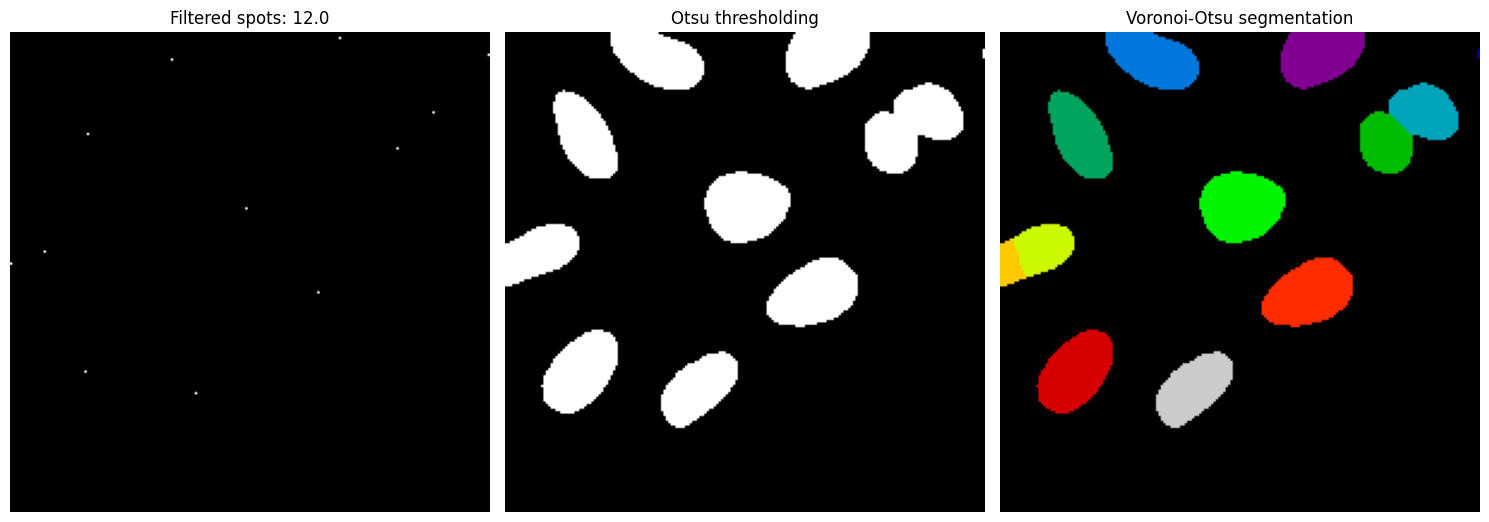

In [28]:
voronoi_segmentation = cle.masked_voronoi_labeling(selected_spots, mask=binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(selected_spots, cmap="gray")
axs[0].set_title(f"Filtered spots: {number_of_filtered_spots}")
axs[1].imshow(binary, cmap="gray")
axs[1].set_title("Otsu thresholding")
axs[2].imshow(voronoi_segmentation, cmap="nipy_spectral")
axs[2].set_title("Voronoi-Otsu segmentation")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

We obtain a semantic instanciated segmentation where our touching object are correctly separated.
> Note: This approach work best on blob shaped object